In [1]:
from __future__ import print_function, division
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from src.annotations.read_annotation import read_annotation
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import cv2 as cv
from src.metrics.model_performance import IoU
from torch.utils.tensorboard import SummaryWriter

plt.ion()   # interactive mode
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.9.0+cu111
Torchvision Version:  0.10.0+cu111


In [9]:
import torch
from torchvision import transforms
from src.deep_learning import Swimnet, train_and_test
from src.preprocessing.dataset import Rescale, ToTensor, Normalize, SwimmerDataset
from torch.utils.data import DataLoader
from skimage import io
from src.annotations.read_annotation import read_annotation

In [12]:
img_dir = "../data/images/"
ant_dir = "../data/annotations/"

input_size = 224
data_transforms = transforms.Compose([
        Rescale((input_size, input_size)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


trainset = SwimmerDataset(img_dir + "Testset", ant_dir + "Testset", transform=data_transforms)
testset = SwimmerDataset(img_dir + "Valset", ant_dir + "Valset", transform=data_transforms)

batch_size = 8
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

Device : cuda:0
[Epoch 1/2] loss: 0.1681, IoU: 20.26% - test_loss: 0.3673, test_IoU: 16.72%
[Epoch 2/2] loss: 0.2221, IoU: 28.25% - test_loss: 0.3361, test_IoU: 19.91%


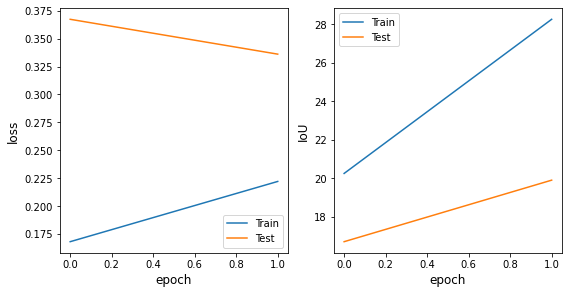

In [3]:
model = Swimnet("resnet18")

criterion = torch.nn.L1Loss(reduction="sum") #torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs = 2

model = train_and_test(model, train_loader, test_loader, criterion, optimizer, max_epochs, tensorboard="test")

In [13]:
nb=37
img = io.imread(f"../data/images/Valset/V4{str(nb).zfill(5)}.jpg")
bb = read_annotation(f"../data/annotations/Valset/V4{str(nb).zfill(5)}.json")
sample = {"image" : img, "bounding_box" : bb}
transf_sample = data_transforms(sample)
model.eval()
pred_bb = model(transf_sample['image'].unsqueeze(0).float().to(device))
pred_bb = pred_bb.cpu().detach().numpy()[0]
pred_bb = [int(pred_bb[0]*640/224), int(pred_bb[1]*480/224), int(pred_bb[2]*640/224), int(pred_bb[3]*480/224)]
x, y, w, h = pred_bb
img = cv.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
x, y, w, h = bb
img = cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
plt.figure(figsize=(10, 10))
plt.imshow(img)

NameError: name 'device' is not defined

### Preprocessing task

### Preparing and Loading data

In [6]:
class SwimmerDataset(Dataset):
    """Swimmer dataset."""

    def __init__(self, img_dir, ant_dir, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            ant_dir (string): Directory with all the annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ant_dir = ant_dir
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        
        # Initialization of the number of frames
        nb_frames = 0
        
        # Reading the info.txt file
        f = open(f"{self.img_dir}/info.txt")
        data = f.readlines()
        f.close()
        
        # Preprocessing to have a structured format
        data_videos = [line.split(";") for line in data]
        data_videos = [[line[0], int(line[1]), int(line[2]), line[3].replace("\n", "")] for line in data_videos]
        
        # Compute the nb of frame
        for video in data_videos:
            nb_frames += video[2]-video[1]
            
        return nb_frames
        

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        filenames = os.listdir(self.img_dir)
        filenames.remove("info.txt")
        filenames.remove("background")
        
        image = io.imread(self.img_dir + "/" + filenames[idx])
        
        ant_name = self.ant_dir + "/" + filenames[idx].split("/")[-1].split(".jpg")[0] + ".json"
        
        bounding_box = read_annotation(ant_name)
        
        sample = {'image': image, 'bounding_box': np.array(bounding_box)}

        if self.transform:
            sample = self.transform(sample)

        return sample

### Train the model

In [64]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
img_dir = "../data/images/"
ant_dir = "../data/annotations/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [65]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [77]:
""" Resnet18
"""
model_ft = models.resnet18(pretrained=True).float()

feature_extractor = nn.Sequential(*list(model_ft.children())[:-2])

for param in feature_extractor.parameters():
    param.requires_grad = False
        
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 4)
input_size = 224

In [78]:
print(feature_extractor)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [68]:
data_transforms = {
    'Valset': transforms.Compose([
        Rescale((input_size, input_size)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testset': transforms.Compose([
        Rescale((input_size, input_size)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [69]:
# Create training and validation dataloaders
dataloaders_dict = {x: DataLoader(SwimmerDataset(img_dir + x, ant_dir + x, transform=data_transforms[x])
                                  , batch_size=batch_size, shuffle=True, num_workers=4) for x in ['Valset', 'Testset']}

In [70]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [71]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.01)

Params to learn:
	 fc.weight
	 fc.bias


In [72]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    
    writer = SummaryWriter('../data/runs/experiment_1')

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000000000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Valset','Testset']:
            if phase == 'Valset':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_IoU = 0

            # Iterate over data.
            for sample_batched in dataloaders[phase]:
                inputs = sample_batched['image']
                bb = sample_batched['bounding_box']
 
                inputs = inputs.to(device)
                bb = bb.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Valset'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    outputs = model(inputs.float())
                    loss = criterion(outputs, bb.float())
                    
                    IoUs = np.array([IoU(outputs[i],bb[i]).cpu().detach().item() for i in range(outputs.shape[0])])

                    # backward + optimize only if in training phase
                    if phase == 'Valset':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_IoU += np.sum(IoUs)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_IoU = running_IoU / len(dataloaders[phase].dataset)
            
            if phase == 'Valset':
                writer.add_scalar('training loss',
                            epoch_loss ,
                            epoch)
                writer.add_scalar('training IoU',
                            epoch_IoU ,
                            epoch)
            else:
                writer.add_scalar('test loss',
                            epoch_loss ,
                            epoch)
                writer.add_scalar('test IoU',
                            epoch_IoU ,
                            epoch)
             

            print('{} Loss: {:.4f} IoU: {:.4f}'.format(phase, epoch_loss, epoch_IoU))
            
            # deep copy the model
            if phase == 'Valset' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    writer.close()
    return model

In [26]:
mean_nm = [0.485, 0.456, 0.406]
std_nm = [0.229, 0.224, 0.225]

In [52]:
def matplotlib_imshow(img):
    img2 = torch.transpose(img, 0, 1)
    img2 = torch.transpose(img2, 1, 2)
    img2[:, :, 0] = img2[:, :, 0]*std_nm[0] + mean_nm[0]
    img2[:, :, 1] = img2[:, :, 1]*std_nm[1] + mean_nm[1]
    img2[:, :, 2] = img2[:, :, 2]*std_nm[2] + mean_nm[2]
    plt.imshow(img2.cpu())
    plt.xticks([], labels=[])
    plt.yticks([], labels=[])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


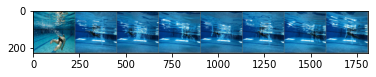

In [53]:
writer = SummaryWriter('../data/runs/experiment_1')

dataiter = iter(dataloaders_dict['Valset'])
sample = dataiter.next()
images = sample['image'].to(device).float()
bbs = sample['bounding_box'].to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid)

# write to tensorboard
writer.add_image('eight_swimmer_images', img_grid)

writer.add_graph(model_ft, images)
writer.close()

In [73]:
#model_ft = torch.load("../models/resnet")

# Setup the loss fxn
criterion = nn.MSELoss()
optimizer_ft = optim.Adam(params_to_update, lr=0.01)
num_epochs = 10

# Train and evaluate
model_ft = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/9
----------
Valset Loss: 1189.1904 IoU: 0.2141
Testset Loss: 1204.7792 IoU: 0.1104

Epoch 1/9
----------
Valset Loss: 403.2513 IoU: 0.3292
Testset Loss: 1196.3795 IoU: 0.1322

Epoch 2/9
----------
Valset Loss: 328.6493 IoU: 0.3692
Testset Loss: 1263.6278 IoU: 0.1239

Epoch 3/9
----------
Valset Loss: 294.9334 IoU: 0.3894
Testset Loss: 1241.5073 IoU: 0.1332

Epoch 4/9
----------
Valset Loss: 244.9183 IoU: 0.4223
Testset Loss: 1232.9293 IoU: 0.1258

Epoch 5/9
----------
Valset Loss: 239.4372 IoU: 0.4251
Testset Loss: 1448.2464 IoU: 0.1442

Epoch 6/9
----------
Valset Loss: 217.0541 IoU: 0.4463
Testset Loss: 1228.8554 IoU: 0.1175

Epoch 7/9
----------
Valset Loss: 197.2342 IoU: 0.4536
Testset Loss: 1294.6587 IoU: 0.1261

Epoch 8/9
----------
Valset Loss: 188.6055 IoU: 0.4652
Testset Loss: 1318.3733 IoU: 0.1235

Epoch 9/9
----------
Valset Loss: 186.8656 IoU: 0.4795
Testset Loss: 1241.8932 IoU: 0.1363

Training complete in 4m 39s


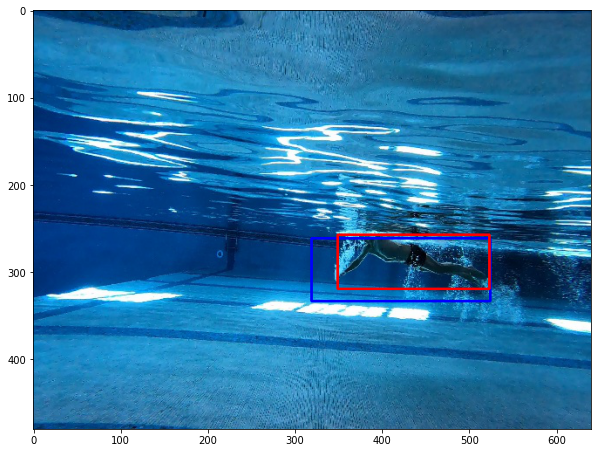

In [30]:
torch.save(model_ft, "../models/resnet")